In [1]:
import pandas as pd
import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

In [2]:
df=pd.read_csv("./dataset/heart.csv")

In [3]:
# Encode categorical features
label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [4]:
# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)



In [5]:

def objective(trial):
    # Define search space for hyperparameters
    num_layers = trial.suggest_int('num_layers', 2, 4)
    num_units = trial.suggest_int('num_units', 16, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 7e-3)
    
    # Build MLP model
    model = Sequential()
    model.add(Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # 2 output classes for this dataset
    
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model with early stopping
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # Evaluate model on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    return val_acc



In [6]:
# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Get best hyperparameters
best_params = study.best_params

[I 2024-05-23 17:59:52,298] A new study created in memory with name: no-name-76932c0c-0bfc-4410-ac62-2508584feb2f
C:\Users\byomo\AppData\Local\Temp\ipykernel_17744\4010384410.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 7e-3)
[I 2024-05-23 17:59:54,424] Trial 0 finished with value: 0.9130434989929199 and parameters: {'num_layers': 2, 'num_units': 99, 'learning_rate': 0.004154253091731497}. Best is trial 0 with value: 0.9130434989929199.
[I 2024-05-23 17:59:56,275] Trial 1 finished with value: 0.8840579986572266 and parameters: {'num_layers': 4, 'num_units': 104, 'learning_rate': 0.0015809253829792422}. Best is trial 0 with value: 0.9130434989929199.
[I 2024-05-23 17:59:57,860] Trial 2 finished with value: 0.9130434989929199 and parameters: {'num_layers': 3, 

In [7]:
# Train final model with best hyperparameters
final_model = Sequential()
final_model.add(Dense(best_params['num_units'], activation='relu', input_shape=(X_train.shape[1],)))
for _ in range(best_params['num_layers'] - 1):
    final_model.add(Dense(best_params['num_units'], activation='relu'))
final_model.add(Dense(2, activation='softmax'))  # 2 output classes for this dataset

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

final_model.fit(X_train, y_train, epochs=15, batch_size=48, verbose=1, validation_data=(X_val, y_val))

# Evaluate final model on test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_acc)

# Predict on test set
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate additional performance metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)

# Print model architecture
final_model.summary()

Epoch 1/15
14/14 [==============================] - 1s 15ms/step - loss: 0.5760 - accuracy: 0.7601 - val_loss: 0.4273 - val_accuracy: 0.8406
Epoch 2/15
14/14 [==============================] - 0s 4ms/step - loss: 0.4010 - accuracy: 0.8380 - val_loss: 0.3590 - val_accuracy: 0.8406
Epoch 3/15
14/14 [==============================] - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8536 - val_loss: 0.3520 - val_accuracy: 0.8623
Epoch 4/15
14/14 [==============================] - 0s 4ms/step - loss: 0.3411 - accuracy: 0.8614 - val_loss: 0.3348 - val_accuracy: 0.8623
Epoch 5/15
14/14 [==============================] - 0s 4ms/step - loss: 0.3252 - accuracy: 0.8676 - val_loss: 0.3413 - val_accuracy: 0.8478
Epoch 6/15
14/14 [==============================] - 0s 4ms/step - loss: 0.3019 - accuracy: 0.8707 - val_loss: 0.3125 - val_accuracy: 0.8913
Epoch 7/15
14/14 [==============================] - 0s 4ms/step - loss: 0.2915 - accuracy: 0.8832 - val_loss: 0.3127 - val_accuracy: 0.8841
Epoch 8/15
14/14 [=

In [8]:
# Calculate additional performance metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
accuracy= accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='binary')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9057971014492754
Precision: 0.9605263157894737
Recall: 0.8795180722891566
F1 Score: 0.9182389937106918


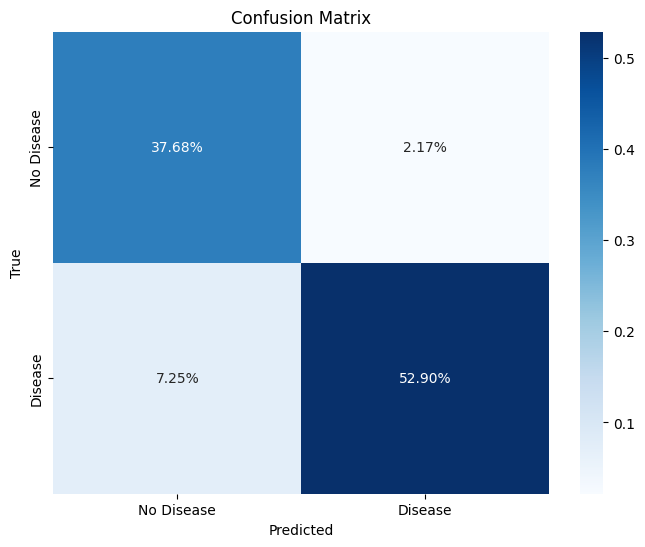

In [9]:
# Plot the confusion matrix using seaborn for better visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        55
           1       0.96      0.88      0.92        83

    accuracy                           0.91       138
   macro avg       0.90      0.91      0.90       138
weighted avg       0.91      0.91      0.91       138



## Saving the Model

In [11]:
'''# Save the model
final_model.save('./models/MLP.h5')'''
